# Import necassary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import wandb
import ast
import re
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
torch.cuda.is_available()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Retrieve first dataset and prepare it for the model

Index(['Unnamed: 0', 'names', 'contents', 'classIndex'], dtype='object')
Index(['contents', 'classIndex'], dtype='object')
[0 1 2]


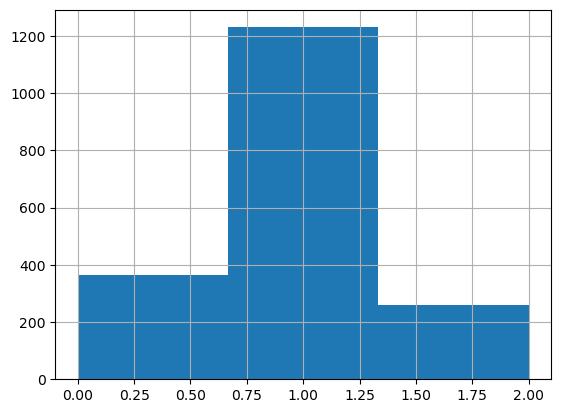

In [2]:
# Define classnames and the used model
classesList = ['andere','factuur','aanmaning']
usedModel = "GroNLP/bert-base-dutch-cased"

# Read data from csv file
Dataset = pd.read_csv(os.getcwd() + "\\test_extraction_emails.csv")
Dataset['classIndex'].hist(bins=3)
print(Dataset.columns)

# Drop unnecessary columns
Dataset = Dataset.drop(['Unnamed: 0','names'],axis=1)
print(Dataset.columns)

# Function to reduce dataset, excluding other/rest category
def reducedDataset(dataset):
    dataset = dataset.drop(dataset[dataset['classIndex'] == 0].index,axis=0)
    dataset.loc[dataset['classIndex'] == 1, 'classIndex'] = 0
    dataset.loc[dataset['classIndex'] == 2, 'classIndex'] = 1
    return dataset

# Setting for choosing between full and reduced dataset
#Dataset = reducedDataset(Dataset)

print(Dataset['classIndex'].unique())

# Retrieve second dataset and prepare it for the model

<AxesSubplot: >

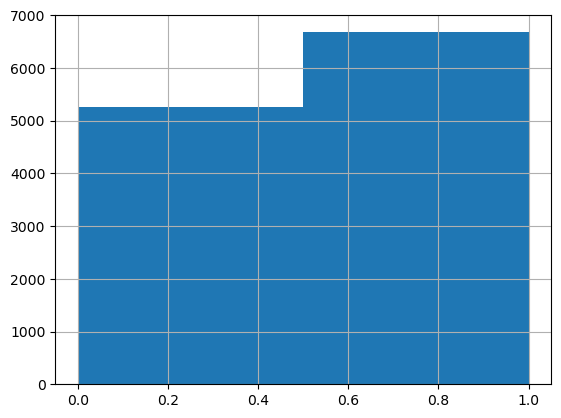

In [6]:
primaryPath = 'email filepath'
usedModel = "bert-base-multilingual-cased"

mailsAndereClean = pd.read_csv(primaryPath + '\Andere.csv')
mailsCNClean = pd.read_csv(primaryPath + '\CN.csv')
mailsOrdersClean = pd.read_csv(primaryPath + '\Orders.csv')
mailsRappelsClean = pd.read_csv(primaryPath + '\Rappels.csv')
mailsTechnoCargoClean = pd.read_csv(primaryPath + '\TechnoCargo.csv')

mailsOrdersClean['classIndex'] = 1
mailsAndereClean['classIndex'] = 0
mailsCNClean['classIndex'] = 0
mailsRappelsClean['classIndex'] = 0
mailsTechnoCargoClean['classIndex'] = 0

Dataset = pd.concat([mailsOrdersClean,mailsAndereClean,mailsCNClean,mailsRappelsClean,mailsTechnoCargoClean])
Dataset = Dataset.drop(['Unnamed: 0'],axis=1)
Dataset['classIndex'].hist(bins=2)

### Split dataset into train/val/test set

In [3]:
trainSet, evalSet = train_test_split(Dataset, test_size=0.25, stratify=Dataset['classIndex'], random_state=42)
valSet, testSet = train_test_split(evalSet, test_size=0.4, stratify=evalSet['classIndex'], random_state=42)

### Define function for calculating class weights + check for usable GPU

In [4]:
#check if CUDA capable gpu is available
cudaAvailable = torch.cuda.is_available()

def calculate_class_weights(trainingDataset):
    weightList = []

    # Get number of labels
    numberOfLabels = len(trainingDataset['classIndex'].unique())
    for i in range(0,numberOfLabels):

        # Calculate class weight with total label count and label count of that class
        weight = len(trainingDataset.index) / (numberOfLabels * len(trainingDataset[trainingDataset['classIndex'] == i].index))
        weightList.append(weight)
    print(weightList)
    return weightList

# Define model/sweep and start training

In [5]:
# Configuration of sweep methods and parameters
sweepConfig = {'method' : 'grid', 'parameters' : {'num_train_epochs' : {'min' : 3, 'max' : 5}, 'learning_rate' : {'values' : [4e-5,5e-5,6e-5]}, 'train_batch_size' : {'values' : [16,32]}}}
sweepID = wandb.sweep(sweepConfig, project='Test sweep')

# Define function for calculating F1-score using method from Scikit-learn
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

# Function to start sweep
def train():
    wandb.init()

    #Further configure sweep
    trainArgumentsSweep = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'wandb_project' : 'Test sweep' + usedModel}
    classifierSweep = ClassificationModel("bert",usedModel, num_labels=len(trainSet['classIndex'].unique()),args=trainArgumentsSweep, use_cuda=True, weight=calculate_class_weights(trainSet), sweep_config=wandb.config)
    classifierSweep.train_model(trainSet)

    # Tabulate results per sweep and log them
    result, model_outputs, wrong_predictions = classifierSweep.eval_model(testSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
    wandb.log({'mcc' : result['mcc'], 'f1' : result['f1'], 'confusion_matrix' : result['confusionMatrix']})
    wandb.join()

# Start sweep    
wandb.agent(sweepID, train)

Create sweep with ID: x5vzuh94
Sweep URL: https://wandb.ai/spacehack100/Test%20sweep/sweeps/x5vzuh94


wandb: Agent Starting Run: 6yvwsygx with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16
wandb: Currently logged in as: spacehack100. Use `wandb login --relogin` to force relogin


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


Training loss,██▁▅▁▄▁▁▄▅▅▁▃▁▁▁▁▆▃▁▁▁▁▂▄▁▁▁▁▂▂▅▇
f1,▁
global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
lr,▄███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
mcc,▁
Training loss,0.54146
f1,0.96901
global_step,1650
lr,0.0
mcc,0.93755


wandb: Agent Starting Run: mkqunku4 with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,▄▄▃█▂▁▃▂▂▁▅▂▁▂▃▁
f1,▁
global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
lr,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
mcc,▁
Training loss,0.01022
f1,0.96901
global_step,800
lr,0.0
mcc,0.93755


wandb: Agent Starting Run: e4hwj308 with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,▅▅▅▄▄▇█▁▂▁▃▁▂▄▁▂▁▁▃▁▃▁▁▁▃▁▁▂▁▂▁▁▃▁▄▁▁▁▃▁
f1,▁
global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▄▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
mcc,▁
Training loss,0.00465
f1,0.96901
global_step,2200
lr,0.0
mcc,0.93726


wandb: Agent Starting Run: xgh8uuni with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,█▅▃▁▂▃▂▅▄▃▃▃▃▃▁▁▁▃▁▅▁▁
f1,▁
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
lr,▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
mcc,▁
Training loss,0.00498
f1,0.96566
global_step,1100
lr,0.0
mcc,0.93068


wandb: Agent Starting Run: 5kvq9vo9 with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,█▇▄▃▂▁▃▄▁▁▁▁▁▁▅▁▁▃▂▁▁▅▃▁▁▁▃▁▆▁▁▁▁▁▁▁▁▁▁▁
f1,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▃▅▇███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
mcc,▁
Training loss,0.00163
f1,0.96482
global_step,2800
lr,0.0
mcc,0.92867


wandb: Agent Starting Run: d9ieempw with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,█▆▄▃▄▃▄▃▂▁▂▂▄▂▂▃▁▃▁▂▃▁▁▁▂▁▁▁
f1,▁
global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
lr,▅██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
mcc,▁
Training loss,0.00284
f1,0.97236
global_step,1400
lr,0.0
mcc,0.9441


wandb: Agent Starting Run: k13uzlu3 with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 3:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,▅▅▅▂▃▂▅▅▃▂▁▄▁▁▁▂▆▂▃▁▄▁▁▁▂▁▁▂▁█▁▂▄
f1,▁
global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
lr,▄███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
mcc,▁
Training loss,0.31466
f1,0.96566
global_step,1650
lr,0.0
mcc,0.93077


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2na4q400 with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,█▄▄▃▁▄▂▁▄▁▁▅▁▄▁▁
f1,▁
global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
lr,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
mcc,▁
Training loss,0.00901
f1,0.96817
global_step,800
lr,0.0
mcc,0.93572


wandb: Agent Starting Run: t929dpnt with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,▇▇▃█▁█▃▄▁▆▁▃▃▄▁▁▂▁▁▁▃▃▁▄▁▁▁▁▁▁▅▁▁▂▁▁▁▁▄▂
f1,▁
global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▄▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
mcc,▁
Training loss,0.06851
f1,0.97236
global_step,2200
lr,0.0
mcc,0.94442


wandb: Agent Starting Run: hb82hhta with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,▆▄▆▂▂▂▅▄▂▂█▁▃▃▂▄▁▁▆▁▁▁
f1,▁
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
lr,▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
mcc,▁
Training loss,0.03033
f1,0.96482
global_step,1100
lr,0.0
mcc,0.92903


wandb: Agent Starting Run: 57xo8z70 with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,█▃▆▂▆▂▄▁▂▃▁▅▃▁▂▁▃▄▁▁▃▁▂▃▁▁▁▁▂▃▁▃▃▃▁▁▁▁▁▁
f1,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▃▅▇███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
mcc,▁
Training loss,0.02702
f1,0.97152
global_step,2800
lr,0.0
mcc,0.94302


wandb: Agent Starting Run: 3lky954i with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,█▅▃▆▇▃▅▆▅▁▁▁▁▅▄▂▁▂▂▃▁▁▃▁▂▁▃▁
f1,▁
global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
lr,▅██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
mcc,▁
Training loss,0.0026
f1,0.96985
global_step,1400
lr,0.0
mcc,0.93886


wandb: Agent Starting Run: ha01s6q7 with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,▆▆▅▃▄▁▁▂▃▁▁█▁▃▄▂▁▁▁▃▆▁▂▁▁▁▁▁█▄▁▁▁
f1,▁
global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
lr,▄███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
mcc,▁
Training loss,0.00731
f1,0.96399
global_step,1650
lr,0.0
mcc,0.92708


wandb: Agent Starting Run: pknzkmkw with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,███▆▂▂▁▃▂▁▁▄▂▂▅▁
f1,▁
global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
lr,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
mcc,▁
Training loss,0.01083
f1,0.96901
global_step,800
lr,0.0
mcc,0.93776


wandb: Agent Starting Run: 9b5p11vm with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,▆▆█▃▄▆▁▄▃▁▅▃▃▃▂▂▆▁▃▄▁▁▅▁▃▄▁▃▃▂▁▅▃▁▁▇▃▁▁▁
f1,▁
global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▄▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
mcc,▁
Training loss,0.01056
f1,0.96734
global_step,2200
lr,0.0
mcc,0.93426


wandb: Agent Starting Run: rq4cg372 with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,▆▃█▁▂▄▁▁▁▁▁▁▂▁▁▂▄▁▁▁▁▁
f1,▁
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
lr,▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
mcc,▁
Training loss,0.00869
f1,0.96734
global_step,1100
lr,0.0
mcc,0.93399


wandb: Agent Starting Run: wkolo9l8 with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/560 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,█▃▁▆▁▆▄▄▄▅▂▁█▁▃▅▄▂▁▄▂▁▁▁▁▁▁▁▁▁▃▂▄▁▁▂▄▁▁▁
f1,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▃▅▇███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
mcc,▁
Training loss,0.00468
f1,0.96399
global_step,2800
lr,0.0
mcc,0.92729


wandb: Agent Starting Run: 6derjn1o with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Training loss,█▃▂▂█▁▂▂▅▃▃▅▂▁▃▂▃▂▁▁▁▁▁▃▂▅▂▁
f1,▁
global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
lr,▅██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
mcc,▁
Training loss,0.00435
f1,0.9732
global_step,1400
lr,0.0
mcc,0.94572


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Move best result into sepperate model

In [7]:
wandb.init()
trainArguments = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'num_train_epochs' : 5, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'train_batch_size' : 32, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'logging_steps' : 25, 'learning_rate' : 6e-5, 'wandb_project' : 'Test seperate' + usedModel, 'wandb_kwargs' : {'magic' : True}}
classifier = ClassificationModel("bert",usedModel, num_labels=len(trainSet['classIndex'].unique()),args=trainArguments, use_cuda=True, weight=calculate_class_weights(trainSet))
classifier.train_model(trainSet)

[1.1341865179929043, 0.8942057942057942]


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/8951 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/280 [00:00<?, ?it/s]

(1400, 0.12718698799111214)

### Evaluate the resulting model against validation set

In [8]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = classifier.eval_model(valSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1790 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/224 [00:00<?, ?it/s]

{'mcc': 0.9366126897728233, 'tp': 970, 'tn': 764, 'fp': 25, 'fn': 31, 'auroc': 0.9908608501764394, 'auprc': 0.9943305080007118, 'f1': 0.9687150837988827, 'confusionMatrix': array([[764,  25],
       [ 31, 970]], dtype=int64), 'eval_loss': 0.13511764440928736}


# Print out emails that were classified wrong

In [ ]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

### Evaluate the resulting model against test set

In [10]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = classifier.eval_model(testSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1194 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

{'mcc': 0.9457653132652268, 'tp': 648, 'tn': 514, 'fp': 13, 'fn': 19, 'auroc': 0.9914852820269182, 'auprc': 0.9939335549290572, 'f1': 0.9731993299832495, 'confusionMatrix': array([[514,  13],
       [ 19, 648]], dtype=int64), 'eval_loss': 0.1278955446338902}


# Print out emails that were classified wrong

In [ ]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

### Save model localy

# Conclusion:
BERTje is able to classify emails with high accuracy and percision, but is significantly slower to train or use inference on. However, this can be mitigated by using a more powerfull gpu (at least for training)
- Avg training time with Nvidia RTX 3070 mobile (at 100W tdp) = ~8 seconds per epoch (batch size of 64)
- Avg training time with Nvidia Quadro t1000 mobile (at 50W tdp) = ~7-8 minutes per epoch (batch size of 16)

Conclusion on data: accuracy is heavily influenced by the amount -> each category will need a lot off data

# Sources:
- https://www.philschmid.de/bert-text-classification-in-a-different-language
- https://huggingface.co/GroNLP/bert-base-dutch-cased
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
- https://huggingface.co/docs/transformers/perf_train_gpu_one
- https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights

# License

BERTje: de Vries, W., van Cranenburgh, A., Bisazza, A., Caselli, T., van Noord, G., & Nissim, M. (2019, December 19). BERTje: A Dutch BERT Model. Groningen, Groningen, Nederland.